In [25]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, freqz, lfilter, spectrogram, stft
from scipy.fft import fftshift

plt.style.use('default')

In [26]:
def oddnumber(x):
    y = int(np.floor(x))
    if y % 2 == 0:
        y = int(np.ceil(x))
    if y % 2 == 0:
        y += 1
    return y

In [27]:
def get_dataset_batches(dataset_dir):
    return list(sorted(filter(lambda d: d.endswith('Dataset'), os.listdir(dataset_dir))))

In [28]:
def get_dataset_files(dataset_dir, dataset_batch):
    return sorted(os.listdir(str(os.path.join(dataset_dir, dataset_batch))))

In [29]:
def preprocess_file(file_path):
    with open(file_path, 'r') as f:
        raw_data = f.read()
        split_data = raw_data.split('\n')

        f_c = float(split_data[0])                          # Center frequency
        T_sweep = float(split_data[1]) / 1000               # Sweep time in seconds
        NTS = int(split_data[2])                            # Number of time samples per sweep
        bw = float(split_data[3])                           # FMCW Bandwidth
        data = split_data[4:]                               # Raw data in I + j * Q format

        fs = NTS/T_sweep                                    # Sampling frequency (ADC)
        record_length = float(len(data)) / fs               # Length of recording in seconds
        n_chirps = math.floor(record_length / T_sweep)      # Number of chirps


        complex_data = np.array([complex(d.replace('i', 'j')) for d in data if len(d.strip()) > 0])
        Data_time = np.reshape(complex_data, (n_chirps, NTS)).T
        win = np.ones_like(Data_time)

        tmp = np.fft.fftshift(np.fft.fft(Data_time * win, axis=0), axes=0)

        Data_range = tmp[NTS//2:NTS, :]

        ns = oddnumber(Data_range.shape[1]) - 1

        Data_range_MTI = np.zeros((Data_range.shape[0], ns), dtype=np.complex128)

        btr = butter(4, 0.0075, btype='high', analog=False)
        b, a = btr

        # h, f1 = freqz(b, a, worN=ns)

        for k in range(Data_range.shape[0]):
            Data_range_MTI[k, :ns] = lfilter(b, a, Data_range[k, :ns])

        freq = np.array(list(range(ns))) * fs / (2 * ns)
        # range_axis = (freq * 3e8 * T_sweep) / (2 * bw)

        Data_range_MTI = Data_range_MTI[1:Data_range_MTI.shape[0], :]
        Data_range = Data_range[1:Data_range_MTI.shape[0], :]

        magnitude_db = 20 * np.log10(np.abs(Data_range) + 1e-12)  # Add small value to avoid log(0)

        #Plot
        plt.figure()
        plt.imshow(magnitude_db, aspect='auto', cmap='jet', origin='lower')

        # Labels and title
        plt.xlabel('No. of Sweeps')
        plt.ylabel('Range bins')
        plt.title('Range Profiles after MTI filter')

        # Y-axis limit
        plt.ylim(1, Data_range_MTI.shape[0] - 1)

        # Match MATLAB clim logic
        vmax = np.max(magnitude_db)
        vmin = np.min(magnitude_db)
        plt.clim(vmin, vmax)

        plt.colorbar(label='Magnitude (dB)')
        plt.draw()
        # plt.show()
        plt.savefig('plot.png')

        bin_indl = 10
        bin_indu = 30

        MD = {}
        MD['PRF'] = 1 / T_sweep
        MD['TimeWindowLength'] = 200
        MD['OverlapFactor'] = 0.95
        MD['OverlapLength'] = round(MD['TimeWindowLength'] * MD['OverlapFactor'])
        MD['Pad_Factor'] = 4
        MD['FFTPoints'] = MD['Pad_Factor'] * MD['TimeWindowLength']
        MD['DopplerBin'] = MD['PRF'] / MD['FFTPoints']
        MD['DopplerAxis'] = np.arange(-MD['PRF'] / 2, MD['PRF'] / 2, MD['DopplerBin'])
        MD['WholeDuration'] = Data_range_MTI.shape[1] / MD['PRF']
        MD['NumSegments'] = int(
            np.floor((Data_range_MTI.shape[1] - MD['TimeWindowLength']) /
                     np.floor(MD['TimeWindowLength'] * (1 - MD['OverlapFactor']))))

        # Initialize accumulation arrays
        Data_spec_MTI2 = 0
        Data_spec2 = 0

        # Accumulate spectrograms over selected range bins
        for RBin in range(bin_indl, bin_indu + 1):
            # MTI version
            f, t, Sxx = spectrogram(
                Data_range_MTI[RBin, :],
                nperseg=MD['TimeWindowLength'],
                noverlap=MD['OverlapLength'],
                nfft=MD['FFTPoints'],
                fs=MD['PRF'],
                window='hamming',
                return_onesided=False,
                mode='complex'

            )
            Data_spec_MTI2 += np.abs(np.fft.fftshift(Sxx, axes=0))

            # Non-MTI version (optional, not visualized here)
            _, _, Sxx2 = spectrogram(
                Data_range[RBin, :],
                nperseg=MD['TimeWindowLength'],
                noverlap=MD['OverlapLength'],
                nfft=MD['FFTPoints'],
                fs=MD['PRF'],
                return_onesided=False,
                mode='complex'
            )
            Data_spec2 += np.abs(np.fft.fftshift(Sxx2, axes=0))

        # Flip vertically to match MATLAB's axis xy
        Data_spec_MTI2 = np.flipud(Data_spec_MTI2)

        #Create velocity axis (assuming 5.8 GHz radar)
        velocity_axis = MD['DopplerAxis'] * 3e8 / 2 / 5.8e9
        MD['TimeAxis'] = np.linspace(0, MD['WholeDuration'], Data_spec_MTI2.shape[1])

        # Plot
        plt.figure()
        plt.imshow(
            20 * np.log10(Data_spec_MTI2 + 1e-12),
            extent=[MD['TimeAxis'][0], MD['TimeAxis'][-1], velocity_axis[0], velocity_axis[-1]],
            aspect='auto',
            cmap='jet',
            origin='lower'
        )
        plt.colorbar(label='Magnitude (dB)')
        plt.ylim([-6, 6])
        plt.xlabel('Time [s]', fontsize=16)
        plt.ylabel('Velocity [m/s]', fontsize=16)
        plt.title('Spectrogram after MTI filter')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        # CLim equivalent
        vmax = np.max(20 * np.log10(Data_spec_MTI2 + 1e-12))
        plt.clim(vmax - 40, vmax)

        plt.show()

        return Data_spec_MTI2.shape


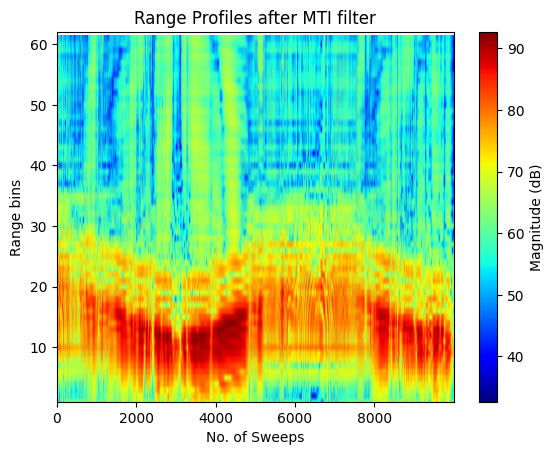

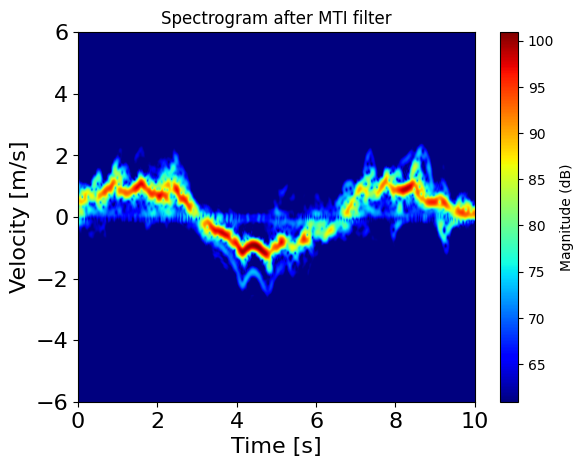

(800, 981)

In [30]:
dataset_dir = 'datasets'
datasets_batches = get_dataset_batches(dataset_dir)
files = get_dataset_files(dataset_dir, datasets_batches[0])

preprocess_file(os.path.join(dataset_dir, datasets_batches[0], files[0]))

In [37]:
import pickle
with open('preprocessed_data/spectrograms.pkl', 'rb') as f:
    spectrograms, spectrograms_MTI, labels = pickle.load(f)

labels


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]